In [2]:
import pandas as pd
import numpy as np

def format_func(value, tick_number):
    if value == 0:
        return "0"
    elif value >= 1000:
        return f"{int(value/1000)}k"
    else:
        return str(int(value))

def get_metric_values(df, input_type, metric_name):
    if input_type not in df["input_type"].unique():
        raise ValueError(f"'{input_type}' is not a valid input_type. "
                         f"Available: {df['input_type'].unique().tolist()}")
    if metric_name not in df["metric_name"].unique():
        raise ValueError(f"'{metric_name}' is not a valid metric_name. "
                         f"Available: {df['metric_name'].unique().tolist()}")
    
    metric_values = df[(df["input_type"] == input_type) &
                       (df["metric_name"] == metric_name)]["value"]
    return metric_values.values

def read_metrics(experiment_key: str) -> [pd.DataFrame, int]:
    experiment_metrics = pd.read_csv(f"loggs/{experiment_key}/metrics.csv")
    num_logged_epochs = experiment_metrics["epoch"].max() + 1
    return experiment_metrics, num_logged_epochs

def get_model_norm(results):
    return results[results["metric_name"] == "weights_l2"] \
        .groupby("epoch")["value"] \
        .apply(lambda x: np.sqrt((x**2).sum())).values

In [7]:
import collections
import math

log_frequency = 1

metrics = collections.defaultdict(lambda: collections.defaultdict(list))

for op in ['add_mod', 'product_mod']:
    for lr in [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]:
        for wd in range(2, 12, 2):
            key = (op, lr, wd)
            for seed in range(64):
                op_str = '' if op == 'add_mod' else f'|binary_operation-{op}'
                seed_str = '' if seed == 42 else f'|seed-{seed}'
                experiment_key = f'add_mod|num_epochs-1001|train_fraction-0.4|log_frequency-1{op_str}|lr-{lr}|batch_size-5107|cross_entropy_dtype-bfloat16|train_dtype-bfloat16|weight_decay-{wd}.0|use_embedding-True|all_reg-True{seed_str}'
                experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
                test_acc = get_metric_values(experiment_metrics, "test", "accuracy")
                s = (test_acc >= 0.95)
                index = np.where(s)[0]
                if index.size > 0:
                    metrics[key]['epoch'].append(index[0])
                    lipschitz_bound = get_metric_values(experiment_metrics, "test", "lipschitz_bound")
                    metrics[key]["lipschitz_bound"].append(lipschitz_bound[index[0]])
                else:
                    metrics[key]['epoch'].append(math.inf)
                    metrics[key]["lipschitz_bound"].append(math.inf)

In [8]:
qualified = {k: v for k, v in metrics.items() if math.inf not in v['epoch']}
print(qualified.keys())

dict_keys([('add_mod', 0.001, 4), ('add_mod', 0.001, 6), ('add_mod', 0.001, 8), ('add_mod', 0.002, 4), ('add_mod', 0.002, 6), ('add_mod', 0.002, 8), ('add_mod', 0.005, 2), ('add_mod', 0.005, 4), ('add_mod', 0.005, 6), ('add_mod', 0.005, 8), ('add_mod', 0.01, 2), ('add_mod', 0.01, 4), ('add_mod', 0.01, 6), ('add_mod', 0.02, 2), ('add_mod', 0.02, 4), ('add_mod', 0.05, 2), ('product_mod', 0.001, 4), ('product_mod', 0.001, 6), ('product_mod', 0.001, 8), ('product_mod', 0.002, 2), ('product_mod', 0.002, 4), ('product_mod', 0.002, 6), ('product_mod', 0.002, 8), ('product_mod', 0.005, 2), ('product_mod', 0.005, 4), ('product_mod', 0.005, 6), ('product_mod', 0.005, 8), ('product_mod', 0.01, 2), ('product_mod', 0.01, 4), ('product_mod', 0.01, 6), ('product_mod', 0.02, 2), ('product_mod', 0.02, 4), ('product_mod', 0.05, 2)])


In [9]:
collections.Counter(k[0] for k in qualified.keys())

Counter({'product_mod': 17, 'add_mod': 16})

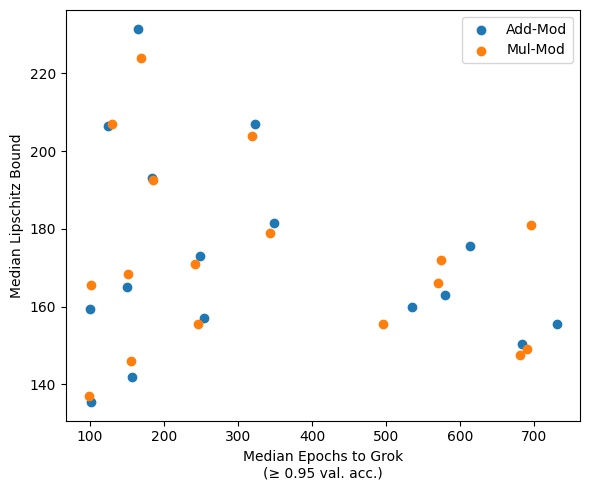

In [10]:
import statistics
import matplotlib.pyplot as plt

add_mod = []
product_mod = []

for k, v in qualified.items():
    xy = tuple(statistics.median(l) for l in [v['epoch'], v['lipschitz_bound']])
    if k[0] == 'add_mod':
        add_mod.append(xy)
    else:
        product_mod.append(xy)

fig, ax = plt.subplots(figsize=(6, 5))

x, y = zip(*add_mod)
ax.scatter(x, y, label='Add-Mod')
x, y = zip(*product_mod)
ax.scatter(x, y, label='Mul-Mod')

ax.set_xlabel('Median Epochs to Grok\n(≥ 0.95 val. acc.)')
ax.set_ylabel('Median Lipschitz Bound')

ax.legend()
plt.tight_layout()
plt.savefig('epoch_lipschitz.png')
plt.show()

In [11]:
import collections
import math

log_frequency = 1

metrics = collections.defaultdict(lambda: collections.defaultdict(list))

for op in ['add_mod', 'product_mod']:
    for lr in [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]:
        for wd in range(2, 12, 2):
            key = (op, lr, wd)
            for seed in range(64):
                op_str = '' if op == 'add_mod' else f'|binary_operation-{op}'
                seed_str = '' if seed == 42 else f'|seed-{seed}'
                experiment_key = f'add_mod|num_epochs-1001|train_fraction-0.4|log_frequency-1{op_str}|lr-{lr}|batch_size-5107|cross_entropy_dtype-bfloat16|train_dtype-bfloat16|weight_decay-{wd}.0|use_embedding-True|all_reg-True|activation_function-GELU{seed_str}'
                experiment_metrics, num_logged_epochs = read_metrics(experiment_key)
                test_acc = get_metric_values(experiment_metrics, "test", "accuracy")
                s = (test_acc >= 0.95)
                index = np.where(s)[0]
                if index.size > 0:
                    metrics[key]['epoch'].append(index[0])
                    lipschitz_bound = get_metric_values(experiment_metrics, "test", "lipschitz_bound")
                    metrics[key]["lipschitz_bound"].append(lipschitz_bound[index[0]])
                else:
                    metrics[key]['epoch'].append(math.inf)
                    metrics[key]["lipschitz_bound"].append(math.inf)

In [12]:
qualified = {k: v for k, v in metrics.items() if math.inf not in v['epoch']}
print(qualified.keys())

dict_keys([('add_mod', 0.001, 4), ('add_mod', 0.001, 6), ('add_mod', 0.002, 2), ('add_mod', 0.002, 4), ('add_mod', 0.002, 6), ('add_mod', 0.002, 8), ('add_mod', 0.005, 2), ('add_mod', 0.005, 4), ('add_mod', 0.005, 6), ('add_mod', 0.01, 2), ('add_mod', 0.01, 4), ('add_mod', 0.02, 2), ('add_mod', 0.02, 4), ('add_mod', 0.05, 2), ('product_mod', 0.001, 4), ('product_mod', 0.001, 6), ('product_mod', 0.002, 2), ('product_mod', 0.002, 4), ('product_mod', 0.002, 6), ('product_mod', 0.005, 2), ('product_mod', 0.005, 4), ('product_mod', 0.005, 6), ('product_mod', 0.01, 2), ('product_mod', 0.01, 4), ('product_mod', 0.02, 2), ('product_mod', 0.02, 4), ('product_mod', 0.05, 2)])


In [13]:
collections.Counter(k[0] for k in qualified.keys())

Counter({'add_mod': 14, 'product_mod': 13})

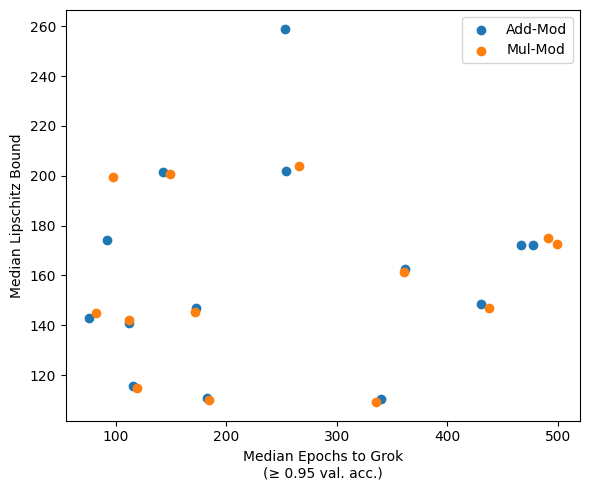

In [14]:
import statistics
import matplotlib.pyplot as plt

add_mod = []
product_mod = []

for k, v in qualified.items():
    xy = tuple(statistics.median(l) for l in [v['epoch'], v['lipschitz_bound']])
    if k[0] == 'add_mod':
        add_mod.append(xy)
    else:
        product_mod.append(xy)

fig, ax = plt.subplots(figsize=(6, 5))

x, y = zip(*add_mod)
ax.scatter(x, y, label='Add-Mod')
x, y = zip(*product_mod)
ax.scatter(x, y, label='Mul-Mod')

ax.set_xlabel('Median Epochs to Grok\n(≥ 0.95 val. acc.)')
ax.set_ylabel('Median Lipschitz Bound')

ax.legend()
plt.tight_layout()
plt.savefig('gelu_epoch_lipschitz.png')
plt.show()